In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('cs-training.csv', index_col=0)

In [3]:
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [3]:
df["NumberOfDependents"] = df["NumberOfDependents"].astype("Int64")

In [4]:
df.fillna({'MonthlyIncome': df['MonthlyIncome'].median(), 'NumberOfDependents': df['NumberOfDependents'].median()}, inplace=True)

In [5]:
df.isnull().sum()

SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Descobrindo Variaveis redundantes e variaveis irrelevantes

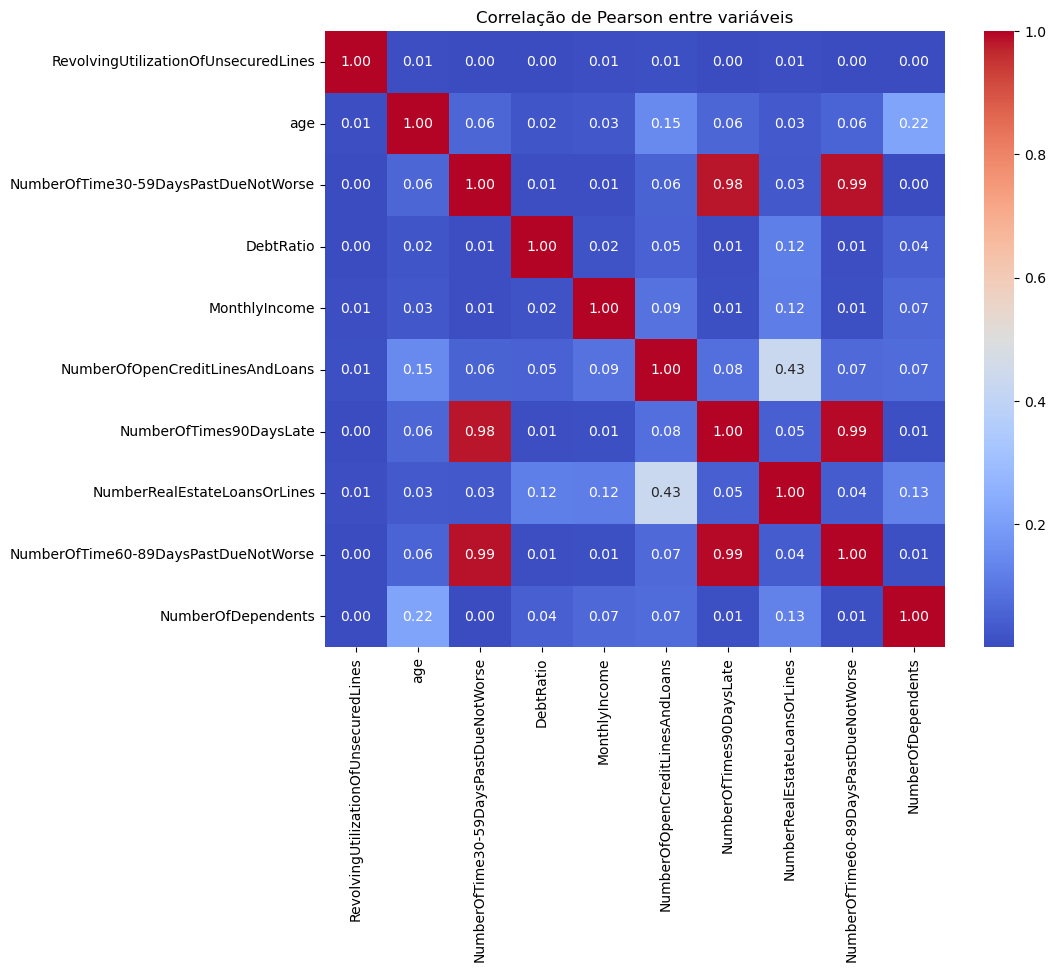

 Pares altamente correlacionados:
NumberOfTime30-59DaysPastDueNotWorse - NumberOfTimes90DaysLate (r=0.98)
NumberOfTime30-59DaysPastDueNotWorse - NumberOfTime60-89DaysPastDueNotWorse (r=0.99)
NumberOfTimes90DaysLate - NumberOfTime60-89DaysPastDueNotWorse (r=0.99)

 Colunas possivelmente redundantes: {'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 'NumberOfTime30-59DaysPastDueNotWorse'}


In [8]:
target = "SeriousDlqin2yrs"
X = df.drop(columns=[target])

threshold = 0.85
corr_matrix = X.corr().abs()

# Pega os pares de variáveis com correlação alta
high_corr_pairs = np.where(corr_matrix > threshold)
high_corr_pairs = [(corr_matrix.columns[x], corr_matrix.columns[y])
                   for x, y in zip(*high_corr_pairs)
                   if x != y and x < y]  

# Extrai todas as variáveis envolvidas
redundantes = set([x for pair in high_corr_pairs for x in pair])

# Visualizar o heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlação de Pearson entre variáveis")
plt.show()
print(" Pares altamente correlacionados:")

for a, b in high_corr_pairs:
    print(f"{a} - {b} (r={corr_matrix.loc[a,b]:.2f})")

print("\n Colunas possivelmente redundantes:", redundantes)


In [9]:
from sklearn.feature_selection import f_classif

# Preencher valores ausentes (ANOVA não aceita NaN)
X_filled = X.fillna(0)

# Calcular F e p-valores
f_values, p_values = f_classif(X_filled, df[target])

# Organizar resultados em tabela
anova_df = pd.DataFrame({
    "Feature": X.columns,
    "F_value": f_values,
    "p_value": p_values
}).sort_values(by="p_value")

print("Resultados da ANOVA F-Test:")
print(anova_df)

# Filtrar colunas irrelevantes (p > 0.05)
irrelevantes = anova_df[anova_df["p_value"] > 0.05]["Feature"].tolist()
print("\nColunas estatisticamente irrelevantes (p > 0.05):", irrelevantes)

Resultados da ANOVA F-Test:
                                Feature      F_value       p_value
1                                   age  2023.993129  0.000000e+00
2  NumberOfTime30-59DaysPastDueNotWorse  2403.692551  0.000000e+00
6               NumberOfTimes90DaysLate  2088.125783  0.000000e+00
8  NumberOfTime60-89DaysPastDueNotWorse  1585.147983  0.000000e+00
9                    NumberOfDependents   330.226608  1.029738e-73
5       NumberOfOpenCreditLinesAndLoans   132.148153  1.430210e-30
4                         MonthlyIncome    44.134710  3.075782e-11
3                             DebtRatio     8.669219  3.236794e-03
7          NumberRealEstateLoansOrLines     7.430531  6.413385e-03
0  RevolvingUtilizationOfUnsecuredLines     0.486807  4.853563e-01

Colunas estatisticamente irrelevantes (p > 0.05): ['RevolvingUtilizationOfUnsecuredLines']


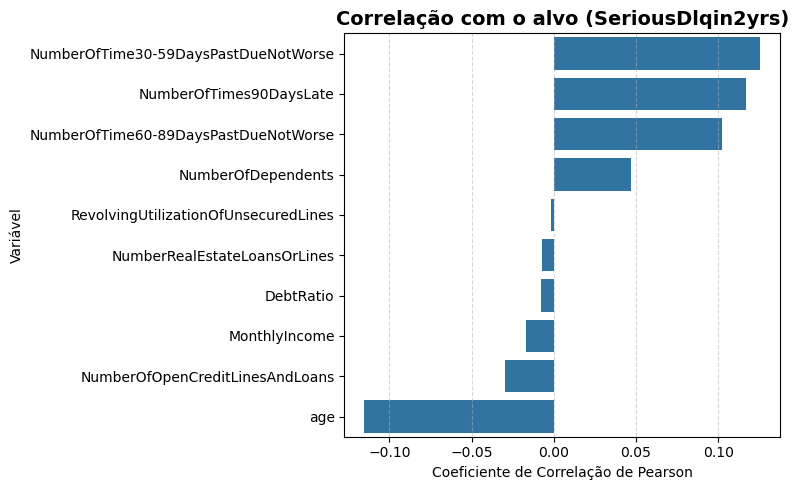

In [10]:
target = 'SeriousDlqin2yrs'
corr_target = df.corr()[target].drop(target).sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=corr_target.values, y=corr_target.index)
plt.title('Correlação com o alvo (SeriousDlqin2yrs)', fontsize=14, weight='bold')
plt.xlabel('Coeficiente de Correlação de Pearson')
plt.ylabel('Variável')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


- A correlação estar negativa em idade significa que ao aumentar o valor de idade o valor de SeriousDlqin2yrs diminui ou seja quanto mais nova a pessoa mais ela tende a ser inadimplente
- Numero de dependentes está 'alta' e faz sentido pois quanto maior o numero de dependentes da renda, maior a chance dessa renda não ser suficiente e por isso a pessoa fica inadimplente
- NumberOfTime está alta entre si por explicarem a mesma coisa apenas com tempos diferentes.
- NumberOfTime está com alta correlação com o SeriousDlqin2yrs pois refletem o mesmo comportamento de inadimplência em períodos anteriores.

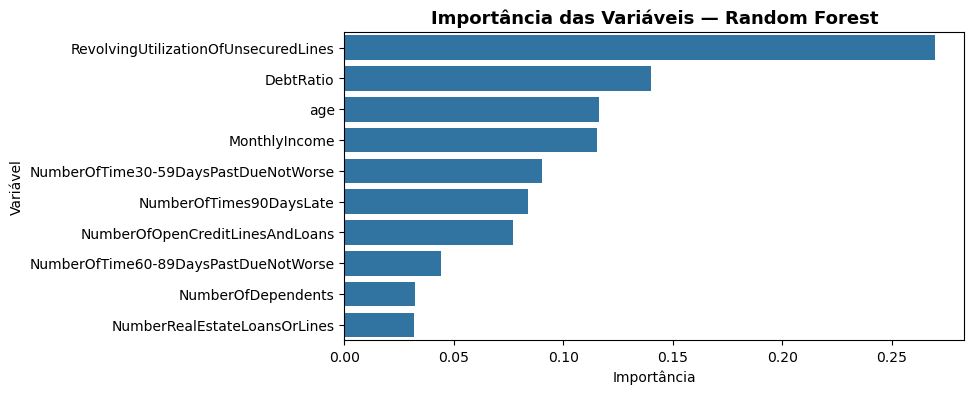

,Variável,Importância
0,RevolvingUtilizationOfUnsecuredLines,0.269606
3,DebtRatio,0.140057
1,age,0.116367
4,MonthlyIncome,0.115325
2,NumberOfTime30-59DaysPastDueNotWorse,0.090007
6,NumberOfTimes90DaysLate,0.083957
5,NumberOfOpenCreditLinesAndLoans,0.076824
8,NumberOfTime60-89DaysPastDueNotWorse,0.044122
9,NumberOfDependents,0.032162
7,NumberRealEstateLoansOrLines,0.031571


In [23]:
from sklearn.ensemble import RandomForestClassifier

# Separar features e alvo
X = df.drop(columns=['SeriousDlqin2yrs'])
y = df['SeriousDlqin2yrs']

# Treinar modelo
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf.fit(X, y)

# Obter importâncias
importances = pd.DataFrame({
    'Variável': X.columns,
    'Importância': rf.feature_importances_
}).sort_values(by='Importância', ascending=False)

# Plotar
plt.figure(figsize=(8,4))
sns.barplot(x='Importância', y='Variável', data=importances)
plt.title('Importância das Variáveis — Random Forest', fontsize=13, weight='bold')
plt.show()

importances


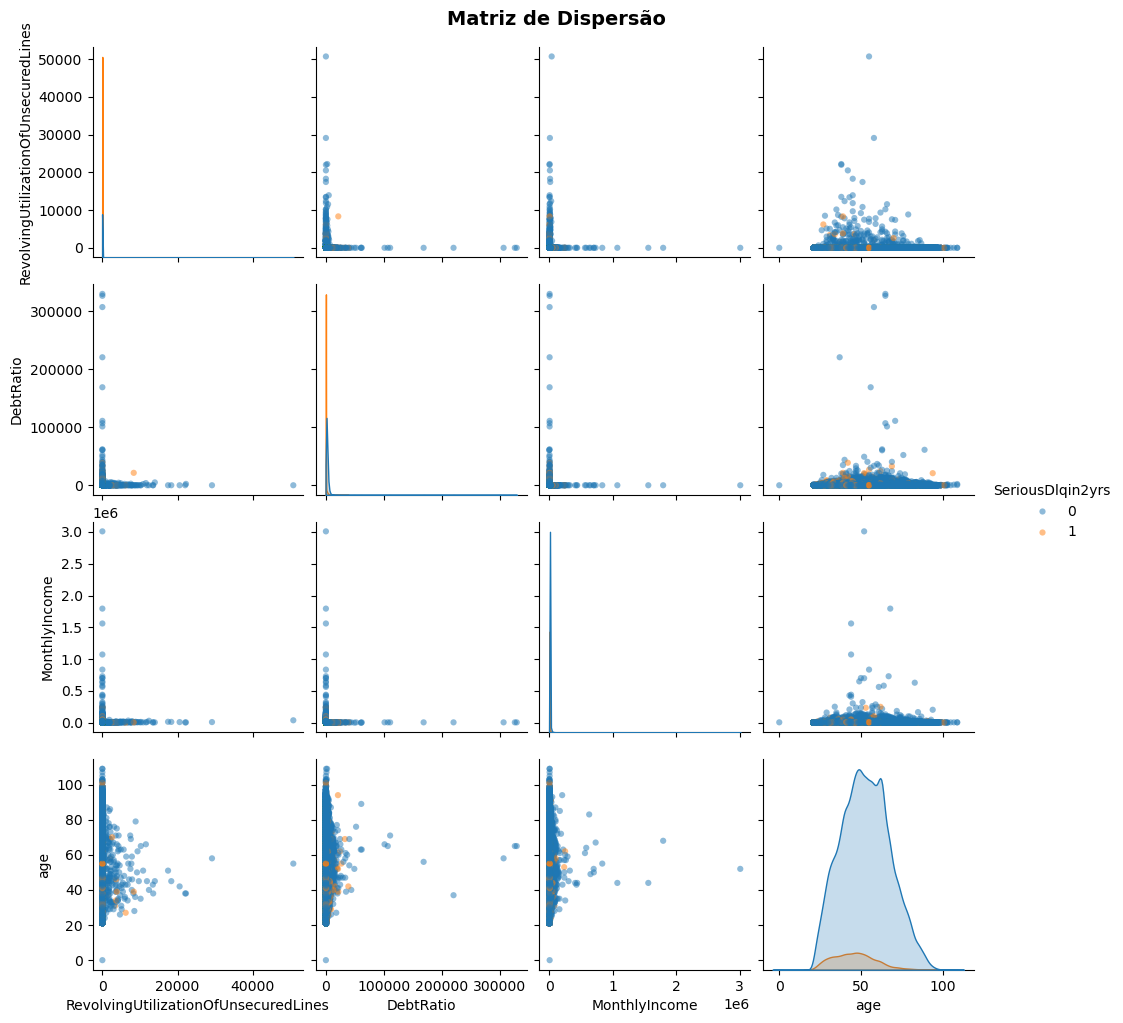

In [14]:
# Selecionar algumas variáveis mais relevantes 
cols_pairplot = [
    'RevolvingUtilizationOfUnsecuredLines',
    'DebtRatio',
    'MonthlyIncome',
    'age',
]

# Criar o pairplot colorindo pelo alvo
sns.pairplot(
    df[cols_pairplot + ['SeriousDlqin2yrs']],
    hue='SeriousDlqin2yrs',
    diag_kind='kde',
    plot_kws={'alpha':0.5, 's':20, 'edgecolor':'none'}
)

plt.suptitle('Matriz de Dispersão', y=1.02, fontsize=14, weight='bold')
plt.show()


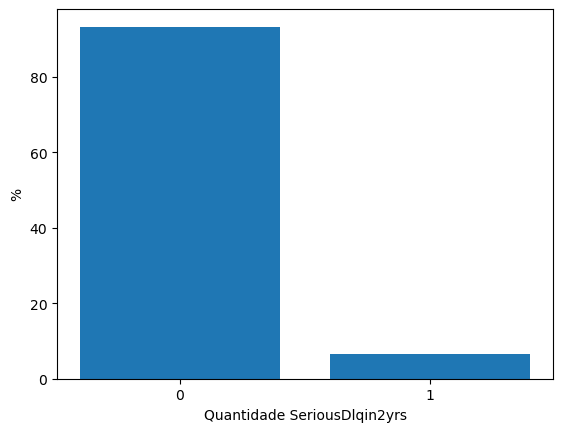

SeriousDlqin2yrs
0    93.316
1     6.684
Name: count, dtype: float64


In [7]:
counts = df['SeriousDlqin2yrs'].value_counts()

percentages = (counts / counts.sum()) * 100

plt.bar(percentages.index, percentages.values)
plt.xlabel('Quantidade SeriousDlqin2yrs')
plt.ylabel('%')
plt.xticks(percentages.index, ['0', '1'])
plt.show()
print(percentages)

In [8]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

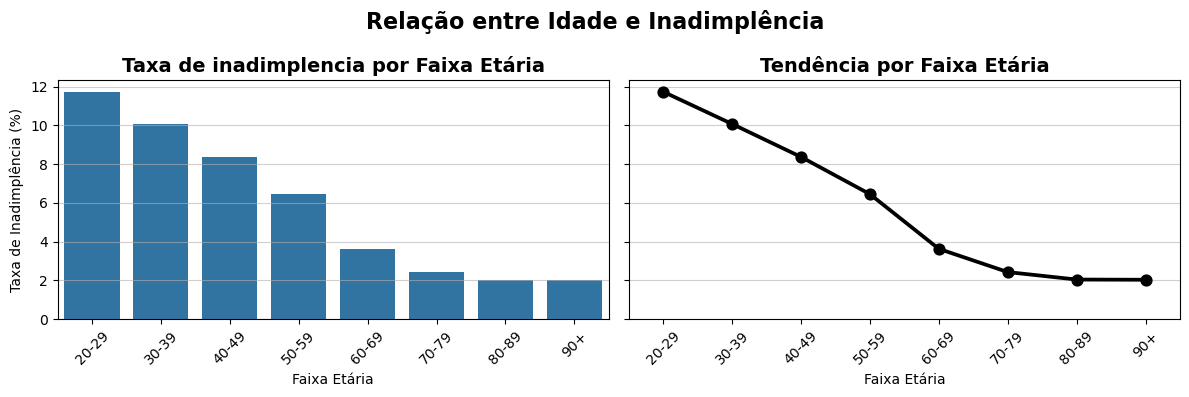

In [67]:
# Agrupar com observed=True
age_bins = [20, 30, 40, 50, 60, 70, 80, 90, 110]
age_labels = ['20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90+']

df['AgeGroup'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=False)

inadimplencia_por_idade = (
    df.groupby('AgeGroup', observed=True)['SeriousDlqin2yrs']
    .mean()
    .reset_index()
)
inadimplencia_por_idade['TaxaInadimplencia'] = inadimplencia_por_idade['SeriousDlqin2yrs'] * 100
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)


sns.barplot(
    x='AgeGroup', y='TaxaInadimplencia',
    data=inadimplencia_por_idade,
     legend=False, ax=axes[0]
)
axes[0].set_title('Taxa de inadimplencia por Faixa Etária', fontsize=14, weight='bold')
axes[0].set_xlabel('Faixa Etária')
axes[0].set_ylabel('Taxa de Inadimplência (%)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.6)


sns.pointplot(
    x='AgeGroup', y='TaxaInadimplencia',
    data=inadimplencia_por_idade, color='black', marker='o', linestyles='-', ax=axes[1]
)
axes[1].set_title('Tendência por Faixa Etária', fontsize=14, weight='bold')
axes[1].set_xlabel('Faixa Etária')
axes[1].set_ylabel('')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.6)

plt.suptitle('Relação entre Idade e Inadimplência', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()


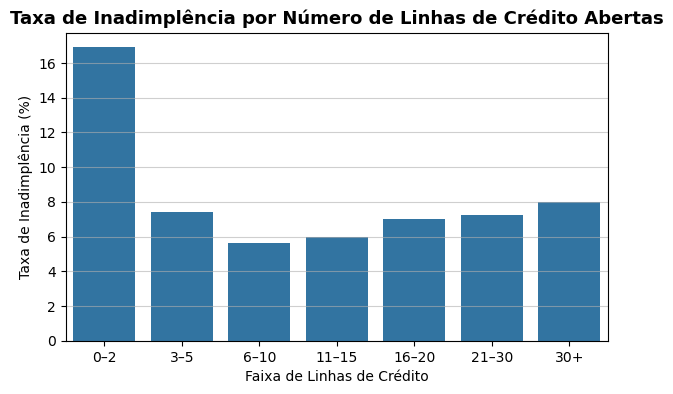

In [64]:

# Agrupar número de linhas em faixas (bins)
df['Faixa_Linhas'] = pd.cut(df['NumberOfOpenCreditLinesAndLoans'],
                            bins=[0, 2, 5, 10, 15, 20, 30, 50],
                            labels=['0–2', '3–5', '6–10', '11–15', '16–20', '21–30', '30+'],
                            right=False)

# Calcular taxa de inadimplência por faixa
inadimplencia_linhas = df.groupby('Faixa_Linhas', observed=True)['SeriousDlqin2yrs'].mean().reset_index()
inadimplencia_linhas['TaxaInadimplencia'] = inadimplencia_linhas['SeriousDlqin2yrs'] * 100

# Plotar
plt.figure(figsize=(7,4))
sns.barplot(x='Faixa_Linhas', y='TaxaInadimplencia', data=inadimplencia_linhas)
plt.title('Taxa de Inadimplência por Número de Linhas de Crédito Abertas', fontsize=13, weight='bold')
plt.xlabel('Faixa de Linhas de Crédito')
plt.ylabel('Taxa de Inadimplência (%)')
plt.grid(axis='y', alpha=0.6)
plt.show()


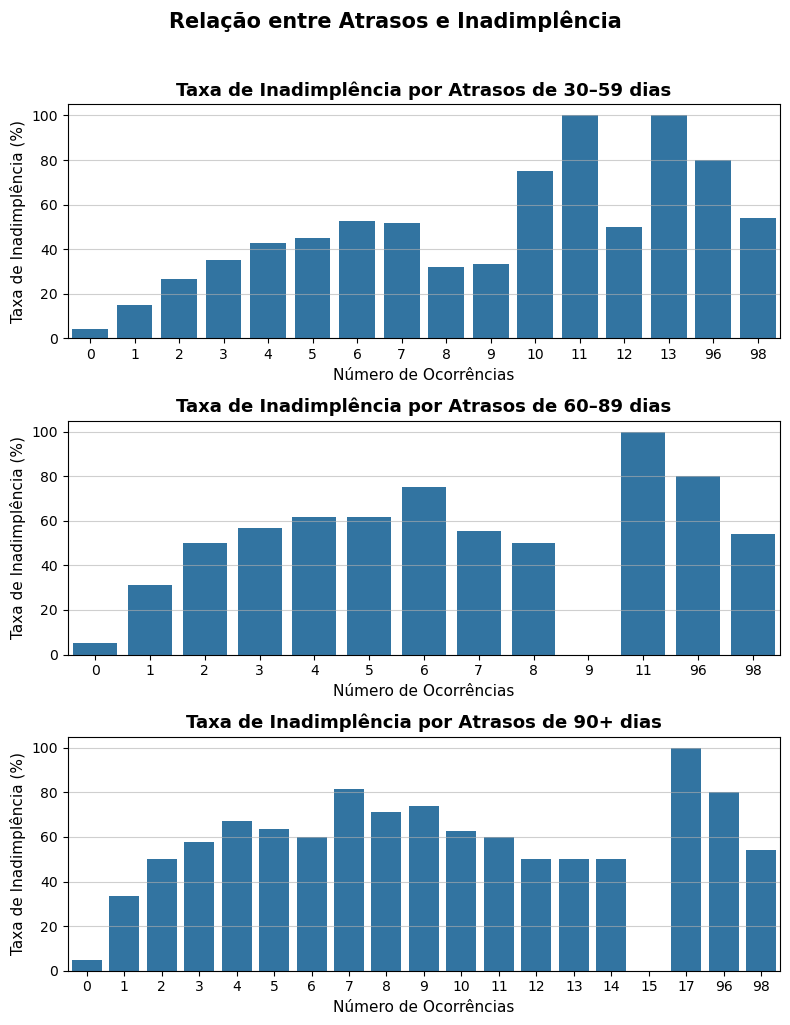

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Lista das variáveis de atraso
cols_atrasos = [
    'NumberOfTime30-59DaysPastDueNotWorse',
    'NumberOfTime60-89DaysPastDueNotWorse',
    'NumberOfTimes90DaysLate'
]

# Títulos simplificados para exibir nos gráficos
titulos_legiveis = [
    'Atrasos de 30–59 dias',
    'Atrasos de 60–89 dias',
    'Atrasos de 90+ dias'
]

# Criar figura com 3 linhas e 1 coluna
fig, axes = plt.subplots(3, 1, figsize=(8, 10), sharey=False)

for i, col in enumerate(cols_atrasos):
    # Agrupar e calcular taxa de inadimplência
    taxa = df.groupby(col, observed=True)['SeriousDlqin2yrs'].mean().reset_index()
    taxa['TaxaInadimplencia'] = taxa['SeriousDlqin2yrs'] * 100

    # Plotar
    sns.barplot(x=col, y='TaxaInadimplencia', data=taxa,
                ax=axes[i])

    axes[i].set_title(f'Taxa de Inadimplência por {titulos_legiveis[i]}',
                      fontsize=13, weight='bold')
    axes[i].set_xlabel('Número de Ocorrências', fontsize=11)
    axes[i].set_ylabel('Taxa de Inadimplência (%)', fontsize=11)
    axes[i].grid(axis='y', alpha=0.6)

plt.suptitle('Relação entre Atrasos e Inadimplência', fontsize=15, weight='bold', y=1.02)
plt.tight_layout()
plt.show()


- Percebo uma relação bem clara entre o número de vezes que a pessoa atrasou pagamentos e a taxa de inadimplência.
Quem já teve algum atraso mesmo que curto, entre 30 e 59 dias já apresenta uma probabilidade bem maior de se tornar inadimplente.
E conforme esses atrasos ficam mais longos ou mais frequentes, o risco cresce de forma ainda mais acentuada, principalmente nos casos de atrasos acima de 90 dias.

In [9]:
df["IncomePerDependent"] = df["MonthlyIncome"] / (df["NumberOfDependents"] + 1)
df["DebtPerLoan"] = df["DebtRatio"] / (df["NumberOfOpenCreditLinesAndLoans"] + 1)

In [10]:
df["Pagamentos_atrasados_Total"] = df['NumberOfTime30-59DaysPastDueNotWorse'] + df['NumberOfTime60-89DaysPastDueNotWorse'] + df['NumberOfTimes90DaysLate']

In [ ]:
df = df.drop(columns=['AgeGroup', 'Faixa_Linhas'])
df.head()

In [12]:
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,IncomePerDependent,DebtPerLoan,Pagamentos_atrasados_Total
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2,3040.0,0.057356,2
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1,1300.0,0.024375,0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0,3042.0,0.028371,2
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0,3300.0,0.006008,0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0,63588.0,0.003116,1


# Processo de Limpeza de outliers

Vamos utilizar o metodo do intervalo Interquartil

In [13]:
# Copiar o dataframe original
df_tratado = df.copy()

# Colunas contínuas (ajuste conforme suas variáveis)
colunas_continuas = [
    'RevolvingUtilizationOfUnsecuredLines',
    'DebtRatio',
    'MonthlyIncome',
    'age',
    'IncomePerDependent',
    'DebtPerLoan'
]

# Aplicar método IQR
for col in colunas_continuas:
    Q1 = df_tratado[col].quantile(0.25)
    Q3 = df_tratado[col].quantile(0.75)
    IQR = Q3 - Q1
    lim_inf = Q1 - 1.5 * IQR
    lim_sup = Q3 + 1.5 * IQR

    df_tratado = df_tratado[
        (df_tratado[col] >= lim_inf) &
        (df_tratado[col] <= lim_sup)
    ]

print(f"✅ Dataset após remoção por IQR: {len(df_tratado)} linhas")


✅ Dataset após remoção por IQR: 103205 linhas


In [14]:
# Colunas de atraso
cols_atrasos = [
    'NumberOfTime30-59DaysPastDueNotWorse',
    'NumberOfTime60-89DaysPastDueNotWorse',
    'NumberOfTimes90DaysLate',
    'Pagamentos_atrasados_Total'
]

# Aplicar winsorização (limitar valores muito altos)
for col in cols_atrasos:
    limite_superior = 20  # você pode ajustar conforme a distribuição
    df_tratado[col] = df_tratado[col].clip(upper=limite_superior)

print("✅ Winsorização aplicada com limite superior de 20 atrasos.")


✅ Winsorização aplicada com limite superior de 20 atrasos.


In [15]:
df_tratado.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,IncomePerDependent,DebtPerLoan,Pagamentos_atrasados_Total
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2,3040.0,0.057356,2
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1,1300.0,0.024375,0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0,3042.0,0.028371,2
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0,3300.0,0.006008,0
6,0,0.213179,74,0,0.375607,3500.0,3,0,1,0,1,1750.0,0.093902,0


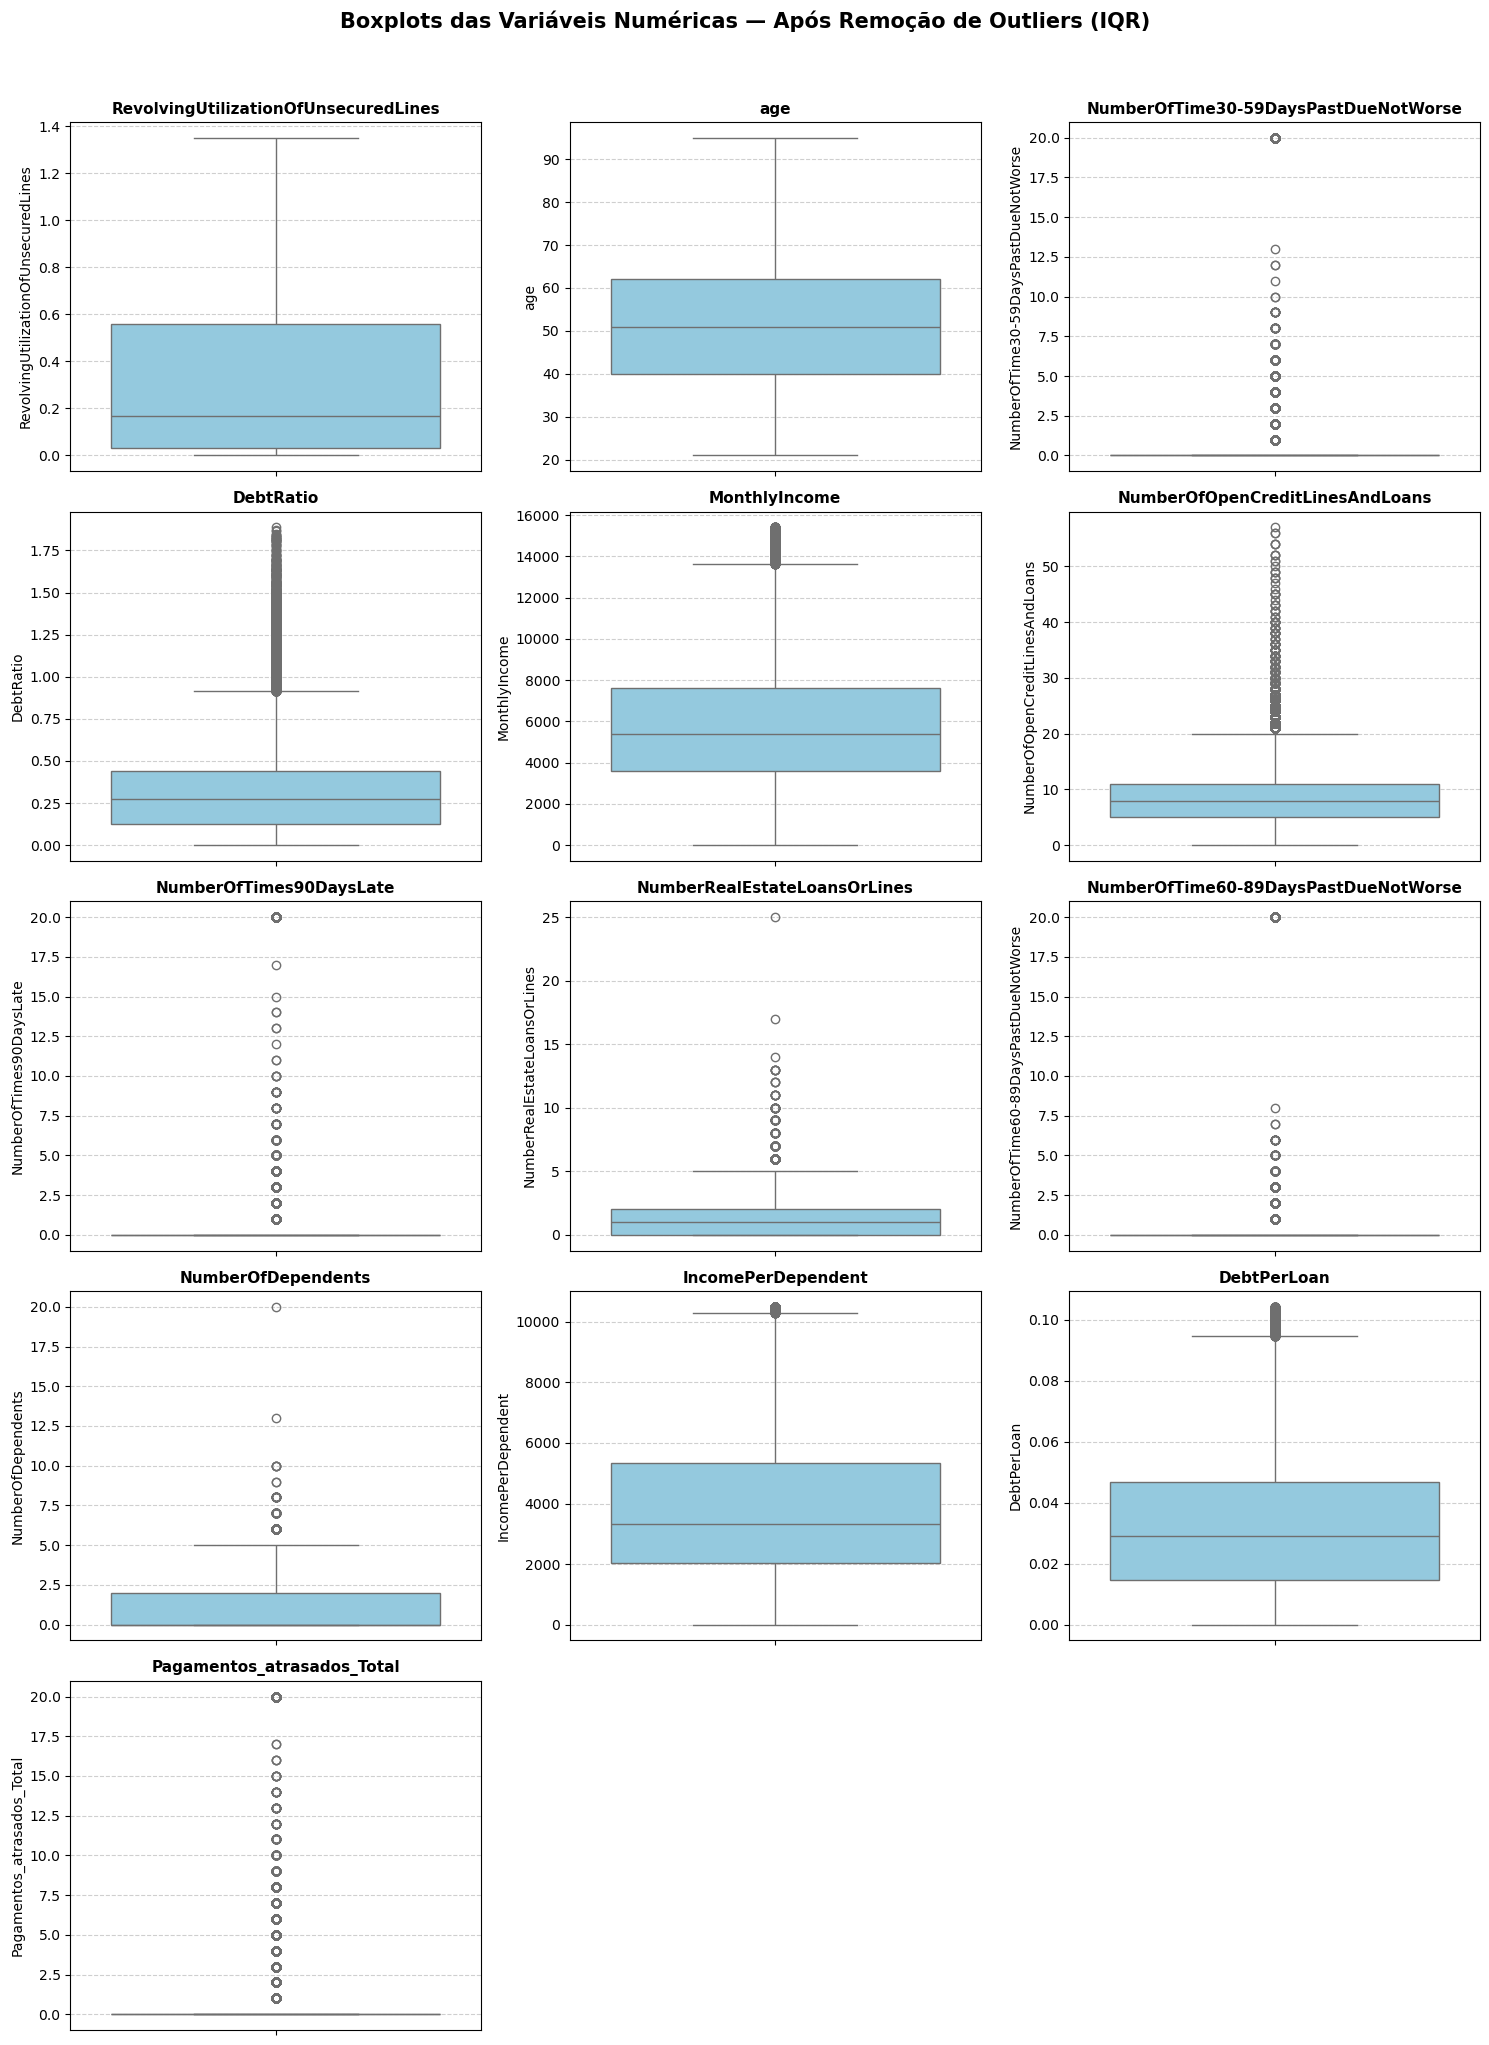

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Selecionar todas as colunas numéricas (exceto o alvo, se quiser)
colunas_numericas = df_tratado.select_dtypes(include=['float64', 'int64']).columns

# Opcional: remover o alvo se quiser visualizar apenas preditoras
colunas_numericas = [c for c in colunas_numericas if c != 'SeriousDlqin2yrs']

# Criar figura com vários subplots (3 colunas por linha)
n_cols = 3
n_rows = (len(colunas_numericas) + n_cols - 1) // n_cols

plt.figure(figsize=(15, n_rows * 4))

for i, col in enumerate(colunas_numericas, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(y=df_tratado[col], color='skyblue')
    plt.title(col, fontsize=11, weight='bold')
    plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.suptitle('Boxplots das Variáveis Numéricas — Após Remoção de Outliers (IQR)', fontsize=15, weight='bold', y=1.02)
plt.tight_layout()
plt.show()


In [17]:
df_tratado.to_parquet('df_tratado.parquet')